<h1><b>Mô hình hóa dữ liệu</b></h1>

<hr/>


<h3><b>Install & Import</b></h3>

Cài đặt và import những thư viện cần thiết cho phần mô hình hóa dữ liệu.

In [1]:
#Cài đặt các thư viện

In [ ]:
#Import các thư viện
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from datetime import timezone
import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

### Bài toán: 

Dự đoán số lượng ứng viên đăng kí một công việc dựa trên các đặc trưng của công việc đó (trình độ, mức lương, quy mô của công ty,...) 

#### Các thuật toán sử dụng:
- Random Forest Regression

### Chuẩn bị dữ liệu

Ở bước này ta sẽ chọn ra những thuộc tính có mức độ liên quan cao, có thể khai thác cho bài toán

In [3]:
#Đọc dữ liệu
data_df = pd.read_csv('data/job_list.csv')
data_df.head()

,Unnamed: 0,jobId,jobTitle,userId,companyLogo,alias,approvedOn,expiredOn,companyName,companyId,...,numOfApplications,isMobileHotJob,isMobileTopJob,isBoldAndRedJob,isUrgentJob,isUrgentJobM,onlineOn,visibilityDisplay,priorityOrder,typeWorkingName
0,0,1581202,Project Management Manager - Attractive Salary...,5975282,https://images.vietnamworks.com/pictureofcompa...,project-management-manager-attractive-salary,2022-11-18 15:59:04+07:00,2022-12-18 23:59:59+07:00,Công Ty TNHH Công Nghệ Welco Việt Nam,313962,...,24,False,False,False,False,False,2022-11-26 11:34:00+07:00,False,2022-11-26 11:34:00,Full-time
1,1,1593683,Production Supervisor,5975282,https://images.vietnamworks.com/pictureofcompa...,production-supervisor-351,2022-11-18 09:38:08+07:00,2022-12-18 23:59:59+07:00,Công Ty TNHH Công Nghệ Welco Việt Nam,313962,...,7,False,False,False,False,False,2022-11-26 11:34:00+07:00,False,2022-11-26 11:34:00,Full-time
2,2,1594103,[Datatech Beeginner] Chuyên Viên Đảm Bảo An Ni...,417756,https://images.vietnamworks.com/pictureofcompa...,datatech-beeginner-chuyen-vien-dam-bao-an-ninh...,2022-11-18 18:08:52+07:00,2022-12-18 23:59:59+07:00,Ngân Hàng Thương Mại Cổ Phần Quân Đội - MB,2332,...,0,True,True,False,True,False,2022-11-26 11:34:00+07:00,False,2022-11-26 11:34:00,Full-time
3,3,1589116,"Trưởng Bộ Phận Tổng Hợp Báo Cáo, Phòng Kế Hoạc...",2859613,https://images.vietnamworks.com/pictureofcompa...,truong-bo-phan-tong-hop-bao-cao-phong-ke-hoach...,2022-11-04 09:59:37+07:00,2022-12-04 23:59:59+07:00,Ngân Hàng TMCP Đại Chúng Việt Nam,136607,...,10,True,True,False,False,False,2022-11-26 11:34:00+07:00,False,2022-11-26 11:34:00,Full-time
4,4,1589145,Lập Trình Viên Java C,1465669,https://images.vietnamworks.com/pictureofcompa...,lap-trinh-vien-java-c-1-1,2022-11-04 10:40:07+07:00,2022-12-04 23:59:59+07:00,Tập Đoàn MK - MK Group,60453,...,3,True,True,False,False,False,2022-11-26 11:34:00+07:00,False,2022-11-26 11:34:00,Full-time


Ở đây, ta có tất cả 38 cột, song ta sẽ bỏ qua các cột quá đặc thù khó có thể khai thác như **jobId**, **jobTitle**, **userId**, **companyLogo**,**alias**,...

Những cột chúng ta sẽ lấy là: **numOfApplications**, **salary**, **skills**, **industries**, **workingLocations**, **jobLevel**, **companySize**, **approvedOn**, **typeWorkingName**

In [4]:
#Lấy ra dữ liệu cần thiết cho dự đoán
application_df = data_df[['numOfApplications','salary','skills','industries','workingLocations','jobLevel','companySize','approvedOn','typeWorkingName']].copy()

### Tiền xử lý

#### Kiểm tra các giá trị thiếu

In [5]:
application_df.isna().sum()

numOfApplications       0
salary                  0
skills                  0
industries              0
workingLocations        0
jobLevel                0
companySize          1189
approvedOn              0
typeWorkingName         0
dtype: int64

Ở cột **companySize**, dữ liệu bị thiếu khá nhiều, việc bỏ đi không phù hợp với trường hợp này vì sẽ làm mất đi lượng thông tin lớn cũng như giảm tính chính xác của bài toán đang xét, vì vậy ta sẽ điền thêm dữ liệu cho các giá trị cột này

Trước hết, cần kiểm tra kiểu dữ liệu và các giá trị của cột `companySize`

In [6]:
application_df['companySize'].head()

0      (100, 499)
1      (100, 499)
2    (1000, 4999)
3    (1000, 4999)
4      (500, 999)
Name: companySize, dtype: object

Dữ liệu ở đây là một object, trước hết chúng ta cần chuyển các dữ liệu này về dạng số và lấy trung bình, sau đó điền các giá trị thiếu bằng giá trị trung vị (tránh trường hợp khi mất cân bằng trong tập dữ liệu) 

In [7]:
#Chuyển dữ liệu từ dạng object sang numberic
application_df['companySize'] = application_df['companySize'].apply(lambda x : math.ceil(np.mean([int(size) for size in str(x).replace('(','').replace(')','').split(',')])) if not isinstance(x, float) else np.nan)

#Bổ sung các giá trị thiếu
median_size = math.floor(application_df['companySize'].median())
application_df['companySize'] = application_df['companySize'].fillna(median_size)

Ngoài ra, có thêm một vấn đề ở cột **salary** khi ở đây có rất nhiều giá trị bằng 0, được xem như những giá trị thiếu (những giá trị mà các nhà tuyển dụng không cung cấp), cũng cần bổ sung bằng giá trị trung vị ở cột này.

In [8]:
application_df['salary'].head()

0       0
1       0
2       0
3    1500
4     700
Name: salary, dtype: int64

In [9]:
median_salary = math.floor(application_df['salary'].loc[application_df['salary'] > 0].median())
application_df['salary'] = application_df['salary'].replace(to_replace = 0, value = median_salary)

#### Chuyển đổi dữ liệu ở các cột dạng `categorical` về dạng `numeric`

Tiến hành chuyển các cột không phải dạng số về số

Ở đây có nhiều cách để chuyển đổi như sử dụng `OrdinalEncoder`, `LabelEncoder`, `OneHotEncoder`,... Trong phần này, ta sẽ dùng `OrdinalEncoder`.

In [10]:
ohe = OneHotEncoder()
encoder_df = pd.DataFrame(ohe.fit_transform(application_df[['jobLevel']]).toarray())
ohe.categories_[0]

m_1 = pd.DataFrame(ohe.fit_transform(application_df[['jobLevel']]).toarray(),columns=ohe.categories_)
m_2 = pd.DataFrame(ohe.fit_transform(application_df[['typeWorkingName']]).toarray(),columns=ohe.categories_)
application_df = pd.concat([application_df,m_1.iloc[:,1:],m_2.iloc[:,1:]],axis=1)
application_df = application_df.drop(['jobLevel','typeWorkingName'], axis=1)

Với những cột có nhiều hơn 1 giá trị, ta sẽ sử dụng `MultiLabelBinarizer`

In [11]:
application_df[['industries','skills','workingLocations']].head()

,industries,skills,workingLocations
0,Executive management;Electrical/Electronics;Pl...,English;Project Management;Communication;OEM M...,Hai Duong
1,Executive management;Production/Process;Electr...,Tiếng Anh;Giám Sát Sản Xuất;Sản Xuất;Điện Tử;Q...,Hai Duong;Hai Duong
2,IT - Software;Banking;IT - Hardware/Networking,Java;.NET;DevOps;Cloud;Kafka,Ha Noi
3,Banking,Ngân Hàng,Ha Noi
4,IT - Software;IT - Hardware/Networking;High Te...,Lập Trình Viên / Software Developer;IT Phần Cứ...,Ha Noi


In [12]:
mlb = MultiLabelBinarizer()
dg_1 = pd.DataFrame(mlb.fit_transform(application_df['skills'].apply(lambda x : x.split(';'))),columns=mlb.classes_)
dg_2 = pd.DataFrame(mlb.fit_transform(application_df['industries'].apply(lambda x : x.split(';'))),columns=mlb.classes_)
dg_3 = pd.DataFrame(mlb.fit_transform(application_df['workingLocations'].apply(lambda x : x.split(';'))),columns=mlb.classes_)

application_df = pd.concat([application_df,dg_1,dg_2,dg_3],axis=1)
application_df = application_df.drop(['skills','industries','workingLocations'], axis=1)



Đối với cột **approvedOn**, các giá trị đang ở dạng chuỗi, ta sẽ chuyển đổi các dữ liệu này về dạng số (hiệu timestamp) với ý nghĩa là số giờ (h) đã đăng tải   

In [13]:
newest_date = application_df['approvedOn'].max()
application_df['approvedOn'] = application_df['approvedOn'].apply(lambda x : round((datetime.datetime.fromisoformat(newest_date).timestamp() - datetime.datetime.fromisoformat(x).timestamp())/3600,0))

Dữ liệu cuối cùng thu được sau khi hoàn tất quá trình tiền xử lý

In [14]:
application_df.head()

,numOfApplications,salary,companySize,approvedOn,"(Experienced (non-manager),)","(Fresher/Entry level,)","(Intern/Student,)","(Manager,)","(Full-time,)","(Internship,)",...,Thai Binh,Thai Nguyen,Thanh Hoa,Thua Thien-Hue,Tien Giang,Tra Vinh,Tuyen Quang,Vinh Long,Vinh Phuc,Yen Bai
0,24,1000,300.0,191.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,7,1000,300.0,198.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,1000,3000.0,189.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,10,1500,3000.0,533.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,3,700,750.0,533.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### Random Forest Regression

Chọn các tập dữ liệu (independent variable) X và tập giá trị (dependent variable) Y cần thiết cho việc mô hình bài toán đang xét

In [15]:
X = application_df.drop(['numOfApplications'], axis=1)
Y = application_df['numOfApplications']

Chia tập bộ dữ liệu thành các tập train (tập huấn luyện) và tập test (Tập kiểm tra)
- Tập train là tập dữ liệu được sử dụng để huấn luyện mô hình. Các thuật toán học máy sẽ học các mô hình từ tập huấn luyện này. Việc học sẽ khác nhau tùy thuộc vào thuật toán và mô hình sử dụng
- Tập test là tập giá trị được sử dụng để đánh giá độ chính xác hoặc sai số của mô hình dự đoán đã được huấn luyện. Ta cần so sánh với tập test để đánh giá khả năng tổng quát hóa với những dữ liệu không chỉ đã học mà còn với những dữ liệu mới, chưa gặp trước đó.

In [16]:
#Ta sẽ chọn 80% cho tập train và 20% cho tập test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

Scale dữ liệu (Feature scaling)

- Đây là một phương pháp được dùng để scale (điều chỉnh) phạm vi của các giá trị để làm cho phù hợp với các giá trị đặc trưng trong tập dữ liệu, đặc biệt đối với những tập có phạm vi chênh lệch lớn.
- Có 2 cách phổ biến để scale dữ liệu đó là Normalization và Standardization. Trong đó Normalization sẽ scale khoảng dữ liệu bất kì về 0 -> 1, còn Standardization sẽ scale dữ liệu về một phân bố trong đó giá trị trung bình của các quan sát là 0 và độ lệch chuẩn là 1.

Ở bài toán này, ta sẽ scale các dữ liệu ở các cột **salary**, **companySize**,**approvedOn** bằng phương pháp Standardization bằng StandardScaler (thư viện có sẵn của scikit-learn)

In [17]:
sc=StandardScaler()
X_train[['salary','companySize','approvedOn']] = sc.fit_transform(X_train[['salary','companySize','approvedOn']])
X_test[['salary','companySize','approvedOn']] = sc.fit_transform(X_test[['salary','companySize','approvedOn']])

Sau khi đã chia các tập dữ liệu và scale, ta tiến hành khởi tạo mô hình Random Forest Regression và đưa tập train vào để tiến hành huấn luyện.

In [18]:
model = RandomForestRegressor(n_estimators = 100, random_state = 0)
model.fit(X_train, Y_train) 

RandomForestRegressor(random_state=0)

Tiến hành dự đoán và đánh giá

In [19]:
Y_pred = model.predict(X_test)

# MAE (Mean Absolute Error)
print('Mean Absolute Error (MAE):', mean_absolute_error(Y_test, Y_pred))
# MSE (Mean Square Error)
print('Mean Squared Error (MSE):', mean_squared_error(Y_test, Y_pred))
# RMSE (Root Mean Square Error)
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(Y_test, Y_pred)))
#R Square
print('R Square (R^2):', r2_score(Y_test,Y_pred))

Mean Absolute Error (MAE): 18.978807231588288
Mean Squared Error (MSE): 1096.7570398535397
Root Mean Squared Error (RMSE): 33.11732235331745
R Square (R^2): 0.18379936712961142


Text(0.5, 0, 'Predicted')

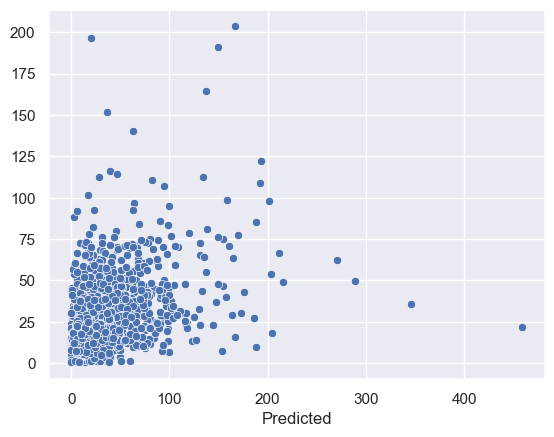

In [20]:
sns.set_theme()
sns.scatterplot(Y_test, Y_pred)
plt.xlabel('Actual')
plt.xlabel('Predicted')